# <font color='#4C6FF3'>Post-Scraping EDA</font>

In [75]:
# Suppress runtime warnings
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [37]:
%matplotlib inline
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.sql import select

## <font color='#52B26C'>Price of Bitcoin</font>

Source: [Bitcoin Price Index (BPI)](http://www.coindesk.com/price/)

In [39]:
db_uri = 'mysql+pymysql://<user_password>@<EC2 DNS>'                                 

engine = create_engine(db_uri)                                                                                                                    
meta = MetaData()                                                           
meta.reflect(bind=engine)                                                   
conn = engine.connect()

In [41]:
bpi = pd.read_sql('''SELECT * FROM coindsk_bpi''', conn)

In [42]:
print bpi.shape
print bpi.info()
bpi.head(2)

(1578, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578 entries, 0 to 1577
Data columns (total 2 columns):
date            1578 non-null object
btc_usd_rate    1578 non-null object
dtypes: object(2)
memory usage: 24.7+ KB
None


,date,btc_usd_rate
0,2013-01-01,13.3041
1,2013-01-02,13.28


In [43]:
print bpi.date.min()
print bpi.date.max()

2013-01-01
2017-05-01


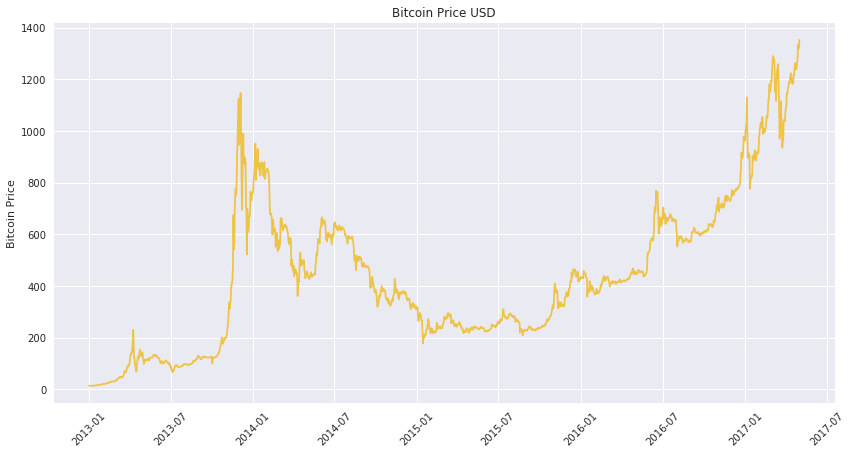

In [45]:
bpi.btc_usd_rate = pd.to_numeric(bpi.btc_usd_rate)
bpi.date         = pd.to_datetime(bpi.date)

plt.figure(figsize=(14,7))
plt.plot(bpi.date, bpi.btc_usd_rate, color='#EFC345')
plt.title('Bitcoin Price USD')
plt.ylabel('Bitcoin Price')
plt.xticks(rotation=45);

## <font color='#52B26C'>Correlations to Price of Bitcoin</font>

###  <font color='purple'>*Google Search Volume*</font>

In [46]:
gsv = pd.read_sql('''SELECT * FROM google_srch_vol''', conn)
gsv.columns = ['searches', 'date']# change `timestp` to `date` to allow merge w/ other DataFrames
gsv.head(2)

,searches,date
0,2,2012-04-08
1,2,2012-04-15


In [47]:
gsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 2 columns):
searches    261 non-null object
date        261 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 4.1+ KB


In [48]:
gsv.searches = pd.to_numeric(gsv.searches)

In [49]:
gsv.isnull().sum() # No missing values

searches    0
date        0
dtype: int64

In [52]:
bpi_2013 = bpi[bpi.date >= '2013-01-01']
bpi_2013.head(2)

,date,btc_usd_rate
0,2013-01-01,13.3041
1,2013-01-02,13.2800


In [53]:
bpi_gsv_2013 = gsv.merge(bpi_2013, on='date')
bpi_gsv_2013.corr()

,searches,btc_usd_rate
searches,1.00000,0.57351
btc_usd_rate,0.57351,1.00000


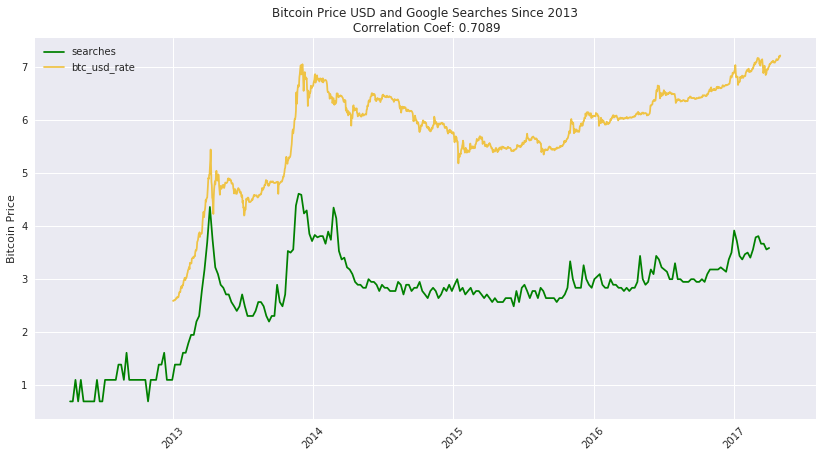

In [59]:
plt.figure(figsize=(14,7))
plt.plot(gsv.date, np.log(gsv.searches), color='green')
plt.plot(bpi_2013.date, np.log(bpi_2013.btc_usd_rate), color='#EFC345')
plt.legend(loc='upper left')
plt.title('Bitcoin Price USD and Google Searches Since 2013\n Correlation Coef: 0.7089')
plt.ylabel('Bitcoin Price')
plt.xticks(rotation=45);

In [55]:
# Plot correlation since 2014
bpi_2014_ = bpi[bpi.date >= '2014-01-01']
gsv_2014_ = gsv[gsv.date >= '2014-01-01']

In [56]:
bpi_gsv_2014 = bpi_2014_.merge(gsv_2014_, on='date')
bpi_gsv_2014.corr()

,btc_usd_rate,searches
btc_usd_rate,1.0000,0.7089
searches,0.7089,1.0000


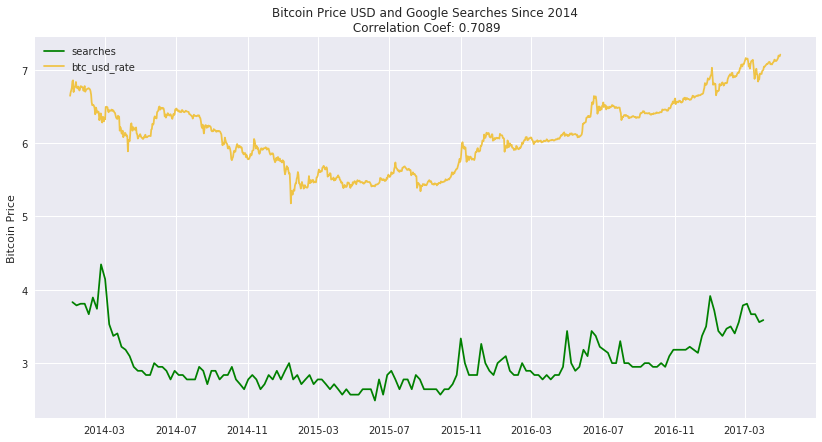

In [57]:
plt.figure(figsize=(14,7))
plt.plot(gsv_2014_.date, np.log(gsv_2014_.searches), color='green')
plt.plot(bpi_2014_.date, np.log(bpi_2014_.btc_usd_rate), color='#EFC345')
plt.title('Bitcoin Price USD and Google Searches Since 2014\n Correlation Coef: 0.7089')
plt.ylabel('Bitcoin Price')
plt.legend(loc='upper left')
plt.show();

### <font color='purple'>*Wikipedia Page Views*</font>

In [60]:
wpv = pd.read_sql('''SELECT * FROM wikipedia_pg_views''', conn)
wpv.columns = ['views', 'date']
wpv.head(2)

,views,date
0,1511,2015-07-01
1,1281,2015-07-02


In [61]:
wpv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
views    600 non-null object
date     600 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 9.4+ KB


In [62]:
wpv.views = pd.to_numeric(wpv.views)

In [63]:
wpv.date.min()

Timestamp('2015-07-01 00:00:00')

In [64]:
# Get BPI since 2015 only
bpi_7_2015 = bpi[bpi.date >= '2015-07-01']
bpi_7_2015.head(2)

,date,btc_usd_rate
911,2015-07-01,257.6604
912,2015-07-02,254.3505


In [65]:
wpv_2015 = wpv.merge(bpi_7_2015, on='date')
wpv_2015.corr()

,views,btc_usd_rate
views,1.000000,0.349038
btc_usd_rate,0.349038,1.000000


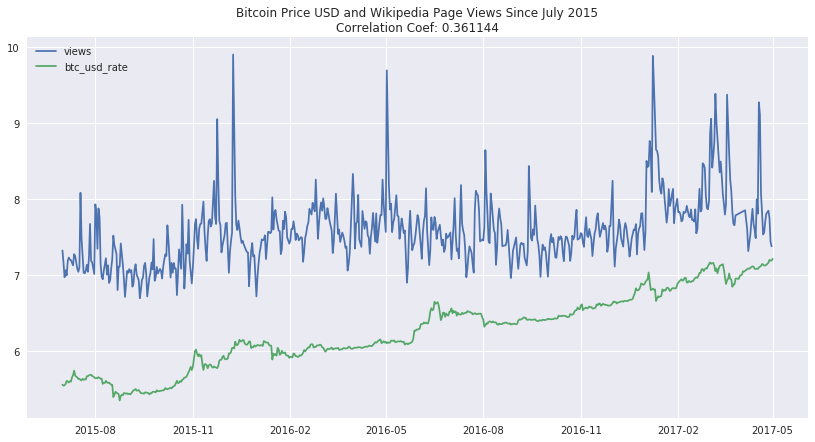

In [66]:
plt.figure(figsize=(14,7))
plt.plot(wpv.date, np.log(wpv.views))
plt.plot(bpi_7_2015.date, np.log(bpi_7_2015.btc_usd_rate))
plt.legend(loc='upper left')
plt.title('Bitcoin Price USD and Wikipedia Page Views Since July 2015\nCorrelation Coef: 0.361144');
plt.show();

In [24]:
# Merge wiki views w/ bpi
w = wpv.merge(bpi, on='date')
w.corr()

,views,btc_usd_rate
views,1.000000,0.361144
btc_usd_rate,0.361144,1.000000


### <font color='purple'>*MyWallet Transactions/Volume*</font>
Source: Quandl

*See* [Blockchain Wallet](https://blockchain.info/wallet/#/)

In [67]:
myW = pd.read_sql('''SELECT * FROM qdl_blkchn_data''', conn)
myW.head(2)

,date,myWallet_trans_day,myWallet_vol
0,2009-01-03,0,0
1,2009-01-04,0,0


In [68]:
myW.dtypes

date                  object
myWallet_trans_day    object
myWallet_vol          object
dtype: object

In [69]:
myW.info()
myW.date               = pd.to_datetime(myW.date)
myW.myWallet_trans_day = pd.to_numeric(myW.myWallet_trans_day)
myW.myWallet_vol       = pd.to_numeric(myW.myWallet_vol)
myW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 3 columns):
date                  3039 non-null object
myWallet_trans_day    3039 non-null object
myWallet_vol          3039 non-null object
dtypes: object(3)
memory usage: 71.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 3 columns):
date                  3039 non-null datetime64[ns]
myWallet_trans_day    3039 non-null int64
myWallet_vol          3039 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 71.3 KB


In [70]:
myW_2013 = myW[myW.date >= '2013-01-01']
myW_2013.corr()

,myWallet_trans_day,myWallet_vol
myWallet_trans_day,1.00000,0.44728
myWallet_vol,0.44728,1.00000


In [71]:
# Merge `myW` DataFrame with bpi
m = myW_2013.merge(bpi, on='date')
m.head()
m.corr()

,myWallet_trans_day,myWallet_vol,btc_usd_rate
myWallet_trans_day,1.000000,0.447620,0.027169
myWallet_vol,0.447620,1.000000,0.044509
btc_usd_rate,0.027169,0.044509,1.000000


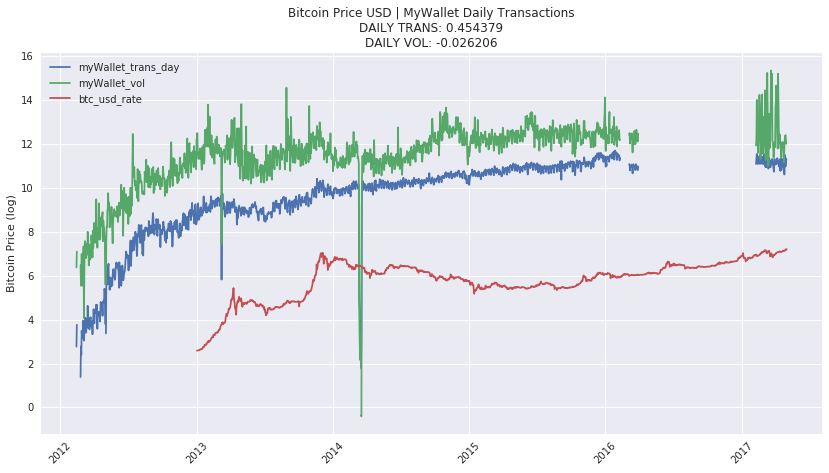

In [76]:
plt.figure(figsize=(14,7))
plt.plot(myW.date, np.log(myW.myWallet_trans_day))
plt.plot(myW.date, np.log(myW.myWallet_vol))
plt.plot(bpi.date, np.log(bpi.btc_usd_rate))
plt.legend(loc='upper left')
plt.title('Bitcoin Price USD | MyWallet Daily Transactions\nDAILY TRANS: 0.454379\nDAILY VOL: -0.026206')
plt.ylabel('Bitcoin Price (log)')
plt.xticks(rotation=45);

### <font color='purple'>*Bitcoin Mining Data*</font>
Source: Quandl

In [77]:
mng = pd.read_sql('''SELECT * FROM qdl_mining_data''', conn)
mng.head(2)

,tot_blkchn_size,avg_blk_size,tot_output_vol,hash_rate_btc,miners_rev,difficulty,timestp,date
0,109509.254778,0.977861424,2476603.4984,3104629.59848,1939250.2,499635929816,2017-04-06 04:18:30,2017-04-05
1,109387.0221,0.878287340909,4163240.21378,4371318.47465,2669294.6,499635929816,2017-04-06 04:18:31,2017-04-04


In [78]:
# mng.info() # Check dtypes before conversion

In [79]:
mng.tot_blkchn_size = pd.to_numeric(mng.tot_blkchn_size)
mng.avg_blk_size    = pd.to_numeric(mng.avg_blk_size)
mng.tot_output_vol  = pd.to_numeric(mng.tot_output_vol)
mng.hash_rate_btc   = pd.to_numeric(mng.hash_rate_btc)
mng.miners_rev      = pd.to_numeric(mng.miners_rev)
mng.difficulty      = pd.to_numeric(mng.difficulty)
mng.date            = pd.to_datetime(mng.date)

In [80]:
# mng.info() # Check dtypes after conversion

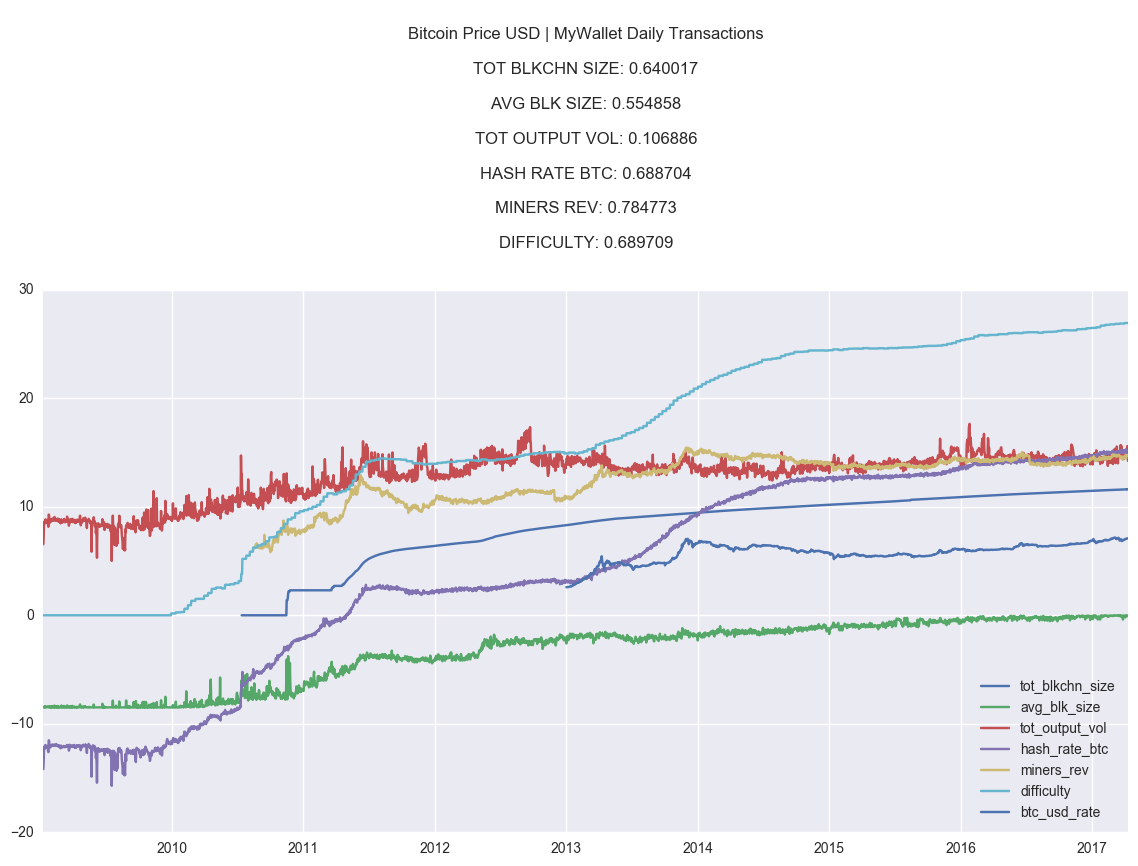

In [85]:
plt.figure(figsize=(14,7))
plt.plot(mng.date, np.log(mng.tot_blkchn_size))
plt.plot(mng.date, np.log(mng.avg_blk_size))
plt.plot(mng.date, np.log(mng.tot_output_vol))
plt.plot(mng.date, np.log(mng.hash_rate_btc))
plt.plot(mng.date, np.log(mng.miners_rev))
plt.plot(mng.date, np.log(mng.difficulty))
plt.plot(bpi.date, np.log(bpi.btc_usd_rate))
plt.legend(loc='lower right')
plt.title('''
Bitcoin Price USD | MyWallet Daily Transactions\n
TOT BLKCHN SIZE: 0.640017\n
AVG BLK SIZE: 0.554858\n
TOT OUTPUT VOL: 0.106886\n
HASH RATE BTC: 0.688704\n
MINERS REV: 0.784773\n
DIFFICULTY: 0.689709\n
''');
# plt.ylabel('Bitcoin Price');
# plt.xticks(rotation=45);

In [95]:
# Plot miners revenue separately
mng_2013 = mng[mng.date >= '2013-01-01']
# mng_2013.head()

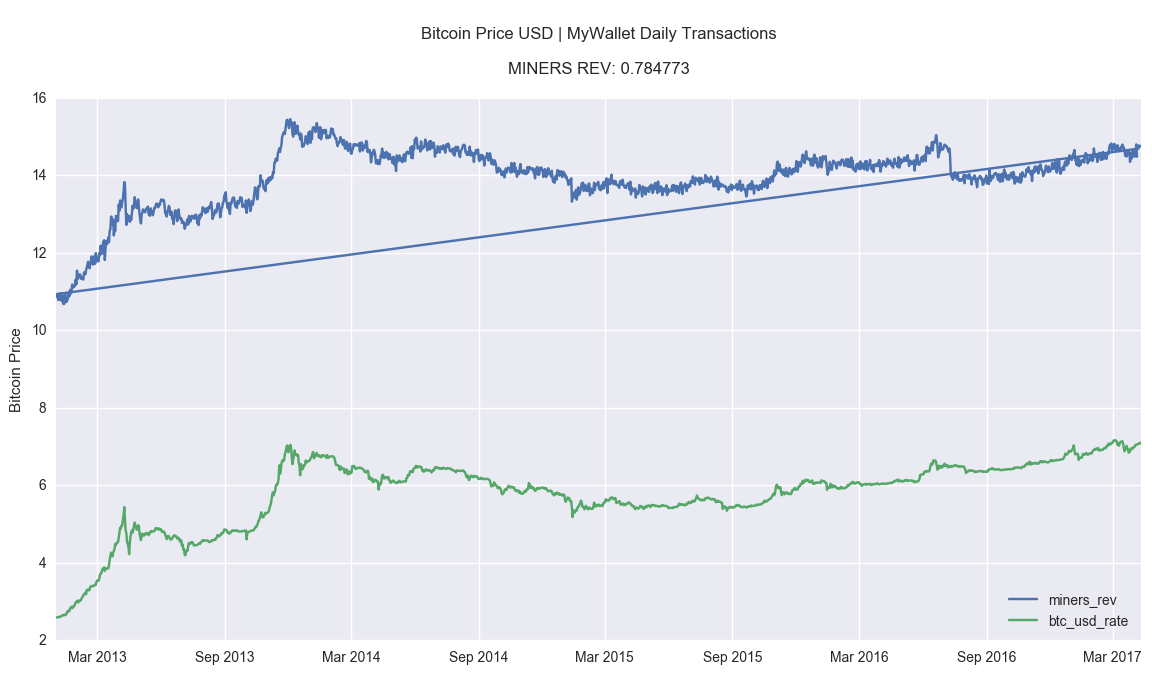

In [96]:
plt.figure(figsize=(14,7))
plt.plot(mng_2013.date, np.log(mng_2013.miners_rev))
plt.plot(bpi.date, np.log(bpi.btc_usd_rate))
plt.legend(loc='lower right')
plt.title('''
Bitcoin Price USD | MyWallet Daily Transactions\n
MINERS REV: 0.784773
''');
plt.ylabel('Bitcoin Price');

# FIX LINE

In [57]:
m = mng.merge(bpi, on='date')
m.corr()

,tot_blkchn_size,avg_blk_size,tot_output_vol,hash_rate_btc,miners_rev,difficulty,btc_usd_rate
tot_blkchn_size,1.000000,0.955924,0.302543,0.949110,0.165836,0.955738,0.640017
avg_blk_size,0.955924,1.000000,0.353052,0.866791,0.126027,0.884218,0.554858
tot_output_vol,0.302543,0.353052,1.000000,0.267228,0.033323,0.264888,0.106886
hash_rate_btc,0.949110,0.866791,0.267228,1.000000,0.189208,0.993322,0.688704
miners_rev,0.165836,0.126027,0.033323,0.189208,1.000000,0.175476,0.784773
difficulty,0.955738,0.884218,0.264888,0.993322,0.175476,1.000000,0.689709
btc_usd_rate,0.640017,0.554858,0.106886,0.688704,0.784773,0.689709,1.000000


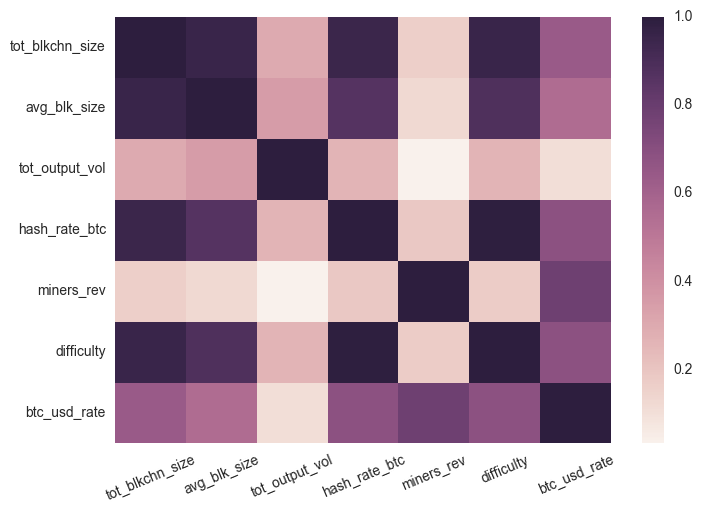

In [65]:
plt.xticks(rotation='23')
sns.heatmap(m.corr());

### <font color='purple'>*Bitcoin Market Data*</font>
Source: Quandl

In [97]:
qmkt = pd.read_sql('''SELECT * FROM qdl_mkt_data''', conn)
qmkt.tail()

,date,tot_BTCs,btc_mkt_cap,tot_btc_addrs,btc_trans_vol,btc_exch_trade_vol,btc_num_trans,btc_tot_trans,trans_less_pop_addrs,trans_per_blk,avg_trans_conf_time,tot_trans_fees_btc,tot_trans_fees_usd,cost_per_trans,cost_as_perct_vol
3013,2017-04-05,16255275,18537515610,496730,299821.151789,67370298.1789,256015,210720088,251099,2048.12,11.5833333333,200.30284512,228425.364575,7.85227570484,0.58795146193
3014,2017-04-06,16257300,18469918530,577216,322587.261122,58001639.013,316555,211036643,311013,1954.04320988,20.625,236.29861443,268458.855854,8.11568718186,0.700988193571
3015,2017-04-07,16259137.5,19525598223.8,548639,310928.713006,92291084.789,290465,211327108,284981,1975.95238095,11.5333333333,221.71976913,266263.270748,8.51364887593,0.662280350123
3016,2017-04-08,16261162.5,19415828025,542131,324783.489424,60427563.1958,295463,211622571,290414,1823.84567901,15.65,225.14679282,268825.270627,9.09310225181,0.692814402854
3017,2017-04-10,16264862.5,19815481983.8,489532,182076.111248,45470746.3671,238286,212087816,234391,1498.65408805,7.6,168.05979031,204747.242535,11.0208677494,1.1838784207


In [98]:
# print 'BEFORE:', qmkt.info()
qmkt.date                 = pd.to_datetime(qmkt.date)
qmkt.tot_BTCs             = pd.to_numeric(qmkt.tot_BTCs)
qmkt.btc_mkt_cap          = pd.to_numeric(qmkt.btc_mkt_cap)
qmkt.tot_btc_addrs        = pd.to_numeric(qmkt.tot_btc_addrs)
qmkt.btc_trans_vol        = pd.to_numeric(qmkt.btc_trans_vol)
qmkt.btc_exch_trade_vol   = pd.to_numeric(qmkt.btc_exch_trade_vol)
qmkt.btc_num_trans        = pd.to_numeric(qmkt.btc_num_trans)
qmkt.btc_tot_trans        = pd.to_numeric(qmkt.btc_tot_trans)
qmkt.trans_less_pop_addrs = pd.to_numeric(qmkt.trans_less_pop_addrs)
qmkt.trans_per_blk        = pd.to_numeric(qmkt.trans_per_blk)
qmkt.avg_trans_conf_time  = pd.to_numeric(qmkt.avg_trans_conf_time)
qmkt.tot_trans_fees_btc   = pd.to_numeric(qmkt.tot_trans_fees_btc)
qmkt.tot_trans_fees_usd   = pd.to_numeric(qmkt.tot_trans_fees_usd)
qmkt.cost_per_trans       = pd.to_numeric(qmkt.cost_per_trans)
qmkt.cost_as_perct_vol    = pd.to_numeric(qmkt.cost_as_perct_vol)
# print '\nAFTER:', qmkt.info()

In [104]:
qmkt_2013 = qmkt[qmkt.date >= '2013-01-01']

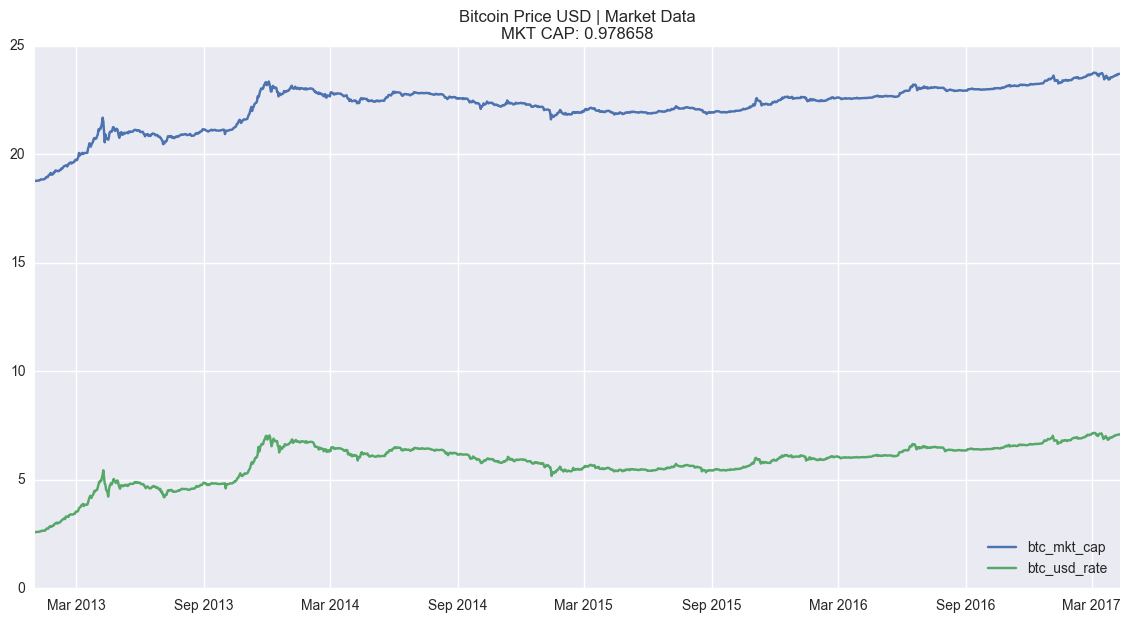

In [106]:
plt.figure(figsize=(14,7))
plt.plot(qmkt_2013.date, np.log(qmkt_2013.btc_mkt_cap))
plt.plot(bpi.date, np.log(bpi.btc_usd_rate))
plt.legend(loc='lower right')
plt.title('Bitcoin Price USD | Market Data\nMKT CAP: 0.978658');

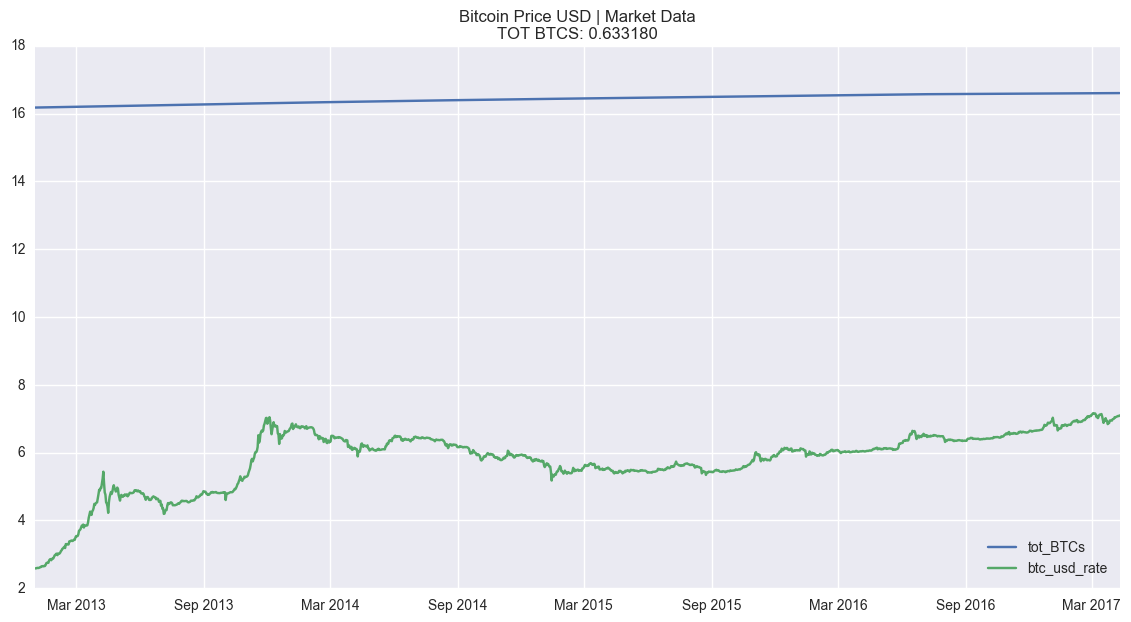

In [110]:
plt.figure(figsize=(14,7))
plt.plot(qmkt_2013.date, np.log(qmkt_2013.tot_BTCs))
plt.plot(bpi.date, np.log(bpi.btc_usd_rate))
plt.legend(loc='lower right')
plt.title('Bitcoin Price USD | Market Data\nTOT BTCS: 0.633180');

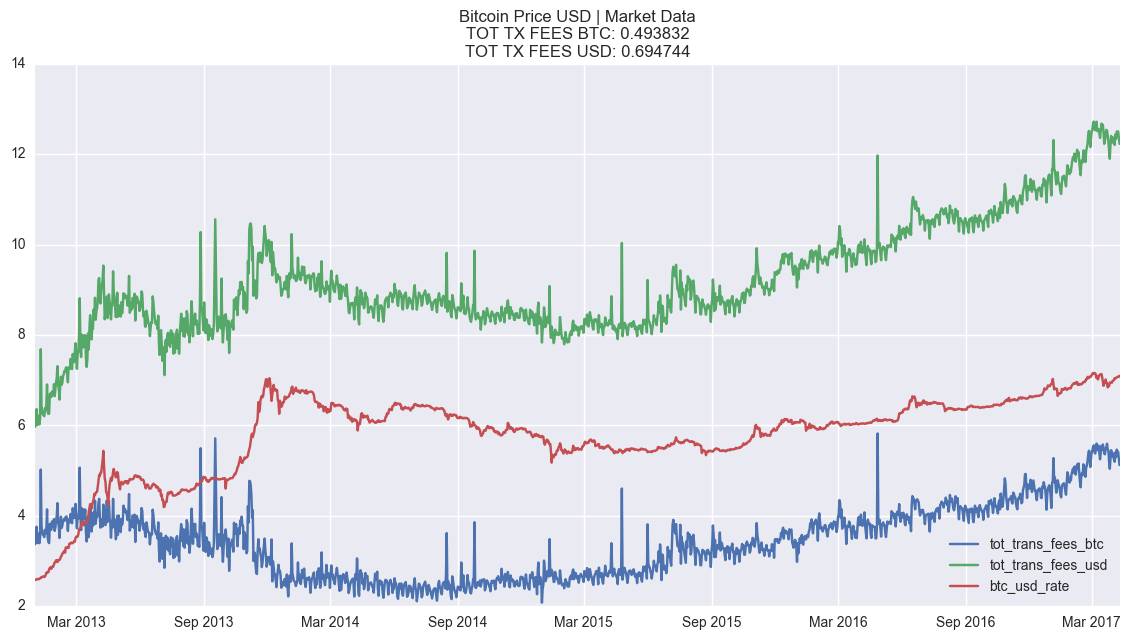

In [114]:
plt.figure(figsize=(14,7))
# plt.plot(qmkt_2013.date, np.log(qmkt_2013.tot_BTCs))
# plt.plot(qmkt.date, np.log(qmkt.btc_mkt_cap))
# plt.plot(qmkt.date, np.log(qmkt.tot_btc_addrs))
# plt.plot(qmkt.date, np.log(qmkt.btc_trans_vol))
# plt.plot(qmkt.date, np.log(qmkt.btc_exch_trade_vol))
# plt.plot(qmkt.date, np.log(qmkt.btc_num_trans))
# plt.plot(qmkt.date, np.log(qmkt.btc_tot_trans))
# plt.plot(qmkt.date, np.log(qmkt.trans_less_pop_addrs))
# plt.plot(qmkt.date, np.log(qmkt.trans_per_blk))
# plt.plot(qmkt.date, np.log(qmkt.avg_trans_conf_time))
plt.plot(qmkt_2013.date, np.log(qmkt_2013.tot_trans_fees_btc))
plt.plot(qmkt_2013.date, np.log(qmkt_2013.tot_trans_fees_usd))
# plt.plot(qmkt.date, np.log(qmkt.cost_per_trans))
# plt.plot(qmkt.date, np.log(qmkt.cost_as_perct_vol))
plt.plot(bpi.date, np.log(bpi.btc_usd_rate))
plt.legend(loc='lower right')
plt.title('Bitcoin Price USD | Market Data\nTOT TX FEES BTC: 0.493832\nTOT TX FEES USD: 0.694744');
# plt.ylabel('Bitcoin Price')
# plt.xticks(rotation=45);

In [78]:
q = qmkt.merge(bpi, on='date')
q.corr()

,tot_BTCs,btc_mkt_cap,tot_btc_addrs,btc_trans_vol,btc_exch_trade_vol,btc_num_trans,btc_tot_trans,trans_less_pop_addrs,trans_per_blk,avg_trans_conf_time,tot_trans_fees_btc,tot_trans_fees_usd,cost_per_trans,cost_as_perct_vol,btc_usd_rate
tot_BTCs,1.000000,0.672974,0.949696,0.364252,0.474536,0.896213,0.934084,0.924327,0.901324,0.406438,0.423848,0.517705,-0.344514,-0.481839,0.568895
btc_mkt_cap,0.672974,1.000000,0.743146,0.105159,0.541332,0.717677,0.776190,0.740859,0.694681,0.517823,0.604279,0.781710,0.194837,-0.167911,0.978658
tot_btc_addrs,0.949696,0.743146,1.000000,0.461741,0.587802,0.971354,0.962748,0.978181,0.951957,0.503605,0.587771,0.648272,-0.361571,-0.540463,0.633180
btc_trans_vol,0.364252,0.105159,0.461741,1.000000,0.564437,0.511061,0.385092,0.479120,0.467419,0.226468,0.328292,0.214462,-0.455998,-0.746035,0.024276
btc_exch_trade_vol,0.474536,0.541332,0.587802,0.564437,1.000000,0.593845,0.546371,0.586430,0.557887,0.339920,0.526553,0.562668,-0.134069,-0.390963,0.485269
btc_num_trans,0.896213,0.717677,0.971354,0.511061,0.593845,1.000000,0.961096,0.986252,0.966168,0.540292,0.669626,0.679547,-0.437028,-0.603208,0.595159
btc_tot_trans,0.934084,0.776190,0.962748,0.385092,0.546371,0.961096,1.000000,0.967484,0.954843,0.543727,0.665711,0.717080,-0.396487,-0.541429,0.653889
trans_less_pop_addrs,0.924327,0.740859,0.978181,0.479120,0.586430,0.986252,0.967484,1.000000,0.957214,0.523512,0.628741,0.664070,-0.390929,-0.573921,0.625762
trans_per_blk,0.901324,0.694681,0.951957,0.467419,0.557887,0.966168,0.954843,0.957214,1.000000,0.557694,0.637898,0.656676,-0.443742,-0.582780,0.569818
avg_trans_conf_time,0.406438,0.517823,0.503605,0.226468,0.339920,0.540292,0.543727,0.523512,0.557694,1.000000,0.599411,0.633472,-0.263245,-0.376191,0.444156


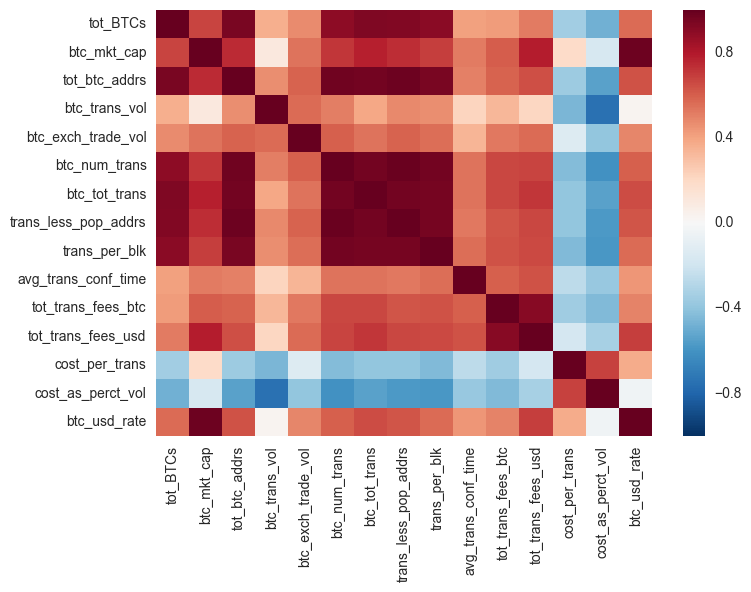

In [76]:
sns.heatmap(q.corr());

###  <font color='purple'>*Twitter Data*</font>

In [184]:
# ADD UID
twts['uid'] = twts.apply(lambda x: str(uuid.uuid1()), axis=1)

In [150]:
# ADD VADER SENTIMENT ANALYSIS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [151]:
analyzer = SentimentIntensityAnalyzer()

In [165]:
twts['pos']      = twts.apply(lambda x: analyzer.polarity_scores(x.tweet)['pos'], axis=1)
twts['neg']      = twts.apply(lambda x: analyzer.polarity_scores(x.tweet)['neg'], axis=1)
twts['neu']      = twts.apply(lambda x: analyzer.polarity_scores(x.tweet)['neu'], axis=1)
twts['compound'] = twts.apply(lambda x: analyzer.polarity_scores(x.tweet)['compound'], axis=1) 

In [183]:
cols = twts.columns.tolist()
cols
cols = [cols[7], cols[0], cols[1], cols[2], cols[3], cols[4], cols[9], cols[8], cols[10], cols[11], cols[5], cols[6]]
cols[4] = 'num_retweets'
cols[5] = 'num_followers'
cols[9] = 'compound'
cols

df = twts[cols]
df.columns
df.dtypes

uid                      object
tweet                    object
polarity                 object
subjectivity             object
num_retweets             object
num_followers            object
neg                     float64
pos                     float64
neu                     float64
compound                float64
created_at       datetime64[ns]
timestp                  object
dtype: object

In [115]:
df.to_sql(name='tweets', con=conn, if_exists='append', index=False)

In [178]:
# twts.head().T

,0,1,2,3,4
tweet,17kc7ncv just won 8.551 Bitcoins at http:// Sa...,17kc7ncv just won 8.551 Bitcoins at http:// Sa...,Is there any way to track the holder of a Bitc...,Bitcoin in danger of becoming a fiat currency?...,3`081 S.DICE @0.00370000BTC = 11.39970000BTC (...
polarity,0.5,0.5,0,0.45,0
subjectivity,0.75,0.75,0,0.85,0
num_retweets,0,0,0,0,0
num_followers,0,0,0,0,0
created_at,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00
timestp,None,None,None,None,None
uid,9220fdf3-1e50-11e7-970f-784f435c68d7,9221068a-1e50-11e7-9a9e-784f435c68d7,92210d38-1e50-11e7-83ca-784f435c68d7,92211363-1e50-11e7-97ad-784f435c68d7,922119ae-1e50-11e7-b850-784f435c68d7
pos,0.266,0.266,0,0,0.225
neg,0,0,0,0.274,0


In [14]:
# print 'BEFORE:', twts.info()
# twts.polarity      = pd.to_numeric(twts.polarity)
# twts.subjectivity  = pd.to_numeric(twts.subjectivity)
# twts.num_retweets  = pd.to_numeric(twts.num_retweets)
# twts.num_followers = pd.to_numeric(twts.num_followers)
# print '\nAFTER:', twts.info()

In [13]:
twts.describe()

,polarity,subjectivity,num_retweets,num_followers
count,950729.000000,950729.000000,950729.0,950729.000000
mean,0.072629,0.262680,0.0,9.029288
std,0.217404,0.322224,0.0,1227.074465
min,-1.000000,0.000000,0.0,0.000000
25%,0.000000,0.000000,0.0,0.000000
50%,0.000000,0.066667,0.0,0.000000
75%,0.125000,0.500000,0.0,0.000000
max,1.000000,1.000000,0.0,953647.000000


In [7]:
jan2013_twts = twts[twts.created_at < '2013-02-01']

In [122]:
# jan2013_twts.head()

In [123]:
# jan2013_twts.count()

In [1]:
plt.figure(figsize=(14,7))
plt.plot(np.log(twts.groupby('created_at').tweet.count()))
plt.plot(bpi.date, np.log(bpi.btc_usd_rate))
plt.legend(loc='upper left')
plt.title('Bitcoin Price USD | Number of Tweets (log)')
plt.legend('Tweet Volume', 'Bitcoin Price', loc='upper left')
# plt.ylabel('Tweets (log)')
plt.xticks(rotation=45);

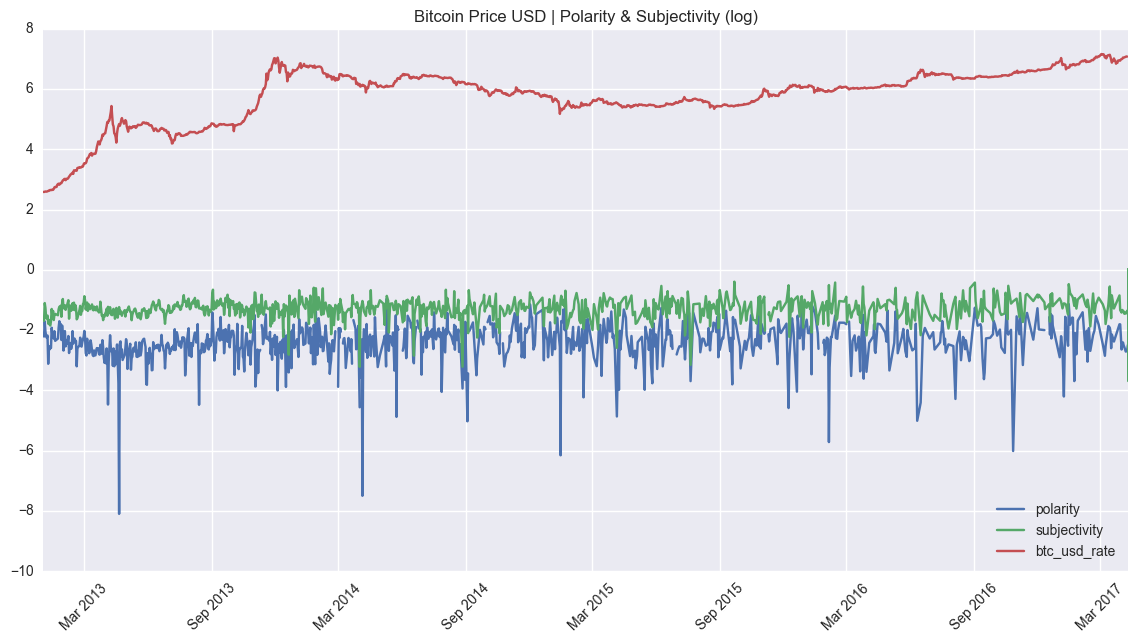

In [111]:
plt.figure(figsize=(14,7))
plt.plot(np.log(twts.groupby('created_at').polarity.mean()))
plt.plot(np.log(twts.groupby('created_at').subjectivity.mean()))
plt.plot(bpi.date, np.log(bpi.btc_usd_rate))
plt.legend(loc='lower right')
plt.title('Bitcoin Price USD | Polarity & Subjectivity (log)')
# plt.ylabel('Tweets (log)')
plt.xticks(rotation=45);

#### VADER for Sentiment Analysis
VADER: <font color='blue'>
**V**alence **A**ware **D**ictionary s**E**ntiment **R**easoner</font>

See [here](https://github.com/cjhutto/vaderSentiment) for more details
 - <font color='red'>***Especially designed for Twitter***</font> (dictionary contains emoticons and slang)
 - Created using human ratings

In [53]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [57]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentences = list(twts.tweet[:20])
analyzer = SentimentIntensityAnalyzer()

In [59]:
analyzer = SentimentIntensityAnalyzer()

<font color='green'>**(normalized, weighted)`compound`**</font> score: sum of valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between 
 - **-1** (most extreme negative) and 
 - **+1** (most extreme positive). 

This is <font color='green'>** the most useful metric if you want a single unidimensional measure of sentiment for a given sentence **</font>. 

**`pos`**, **`neu`**, and **`neg`**: ratios for proportions of text that fall in each category

In [156]:
analyzer = SentimentIntensityAnalyzer()
for sentence in sentences[:3]:
    vs = analyzer.polarity_scores(sentence)
    print '{} \n\t{}'.format(sentence, str(vs))
    

17kc7ncv just won 8.551 Bitcoins at http:// SatoshiDice.com ! #winning #casino #gambling #bitcoin 
	{'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'compound': 0.6114}
17kc7ncv just won 8.551 Bitcoins at http:// SatoshiDice.com ! #winning #casino #gambling #bitcoin 
	{'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'compound': 0.6114}
Is there any way to track the holder of a Bitcoin account? http:// cur.lv/ecvy #cryptocurrent 
	{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [159]:
for sentence in sentences[:3]:
    vs_neg = analyzer.polarity_scores(sentence)['neg']
    vs_pos = analyzer.polarity_scores(sentence)['pos']
    vs_neu = analyzer.polarity_scores(sentence)['neu']
    vs_cpd = analyzer.polarity_scores(sentence)['compound']
    print
    print 'Neg:', vs_neg
    print 'Neu:', vs_neu
    print 'Pos:', vs_pos
    print 'Cpd:', vs_cpd


Neg: 0.0
Neu: 0.734
Pos: 0.266
Cpd: 0.6114

Neg: 0.0
Neu: 0.734
Pos: 0.266
Cpd: 0.6114

Neg: 0.0
Neu: 1.0
Pos: 0.0
Cpd: 0.0
